# Description

This notebook contains an attempt to model a quadratic equation with ReLU and simple torch tensors. We will not be calculating the gradients from scratch, instead we will use `loss.backward` from `torch.tensor`

In [3]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

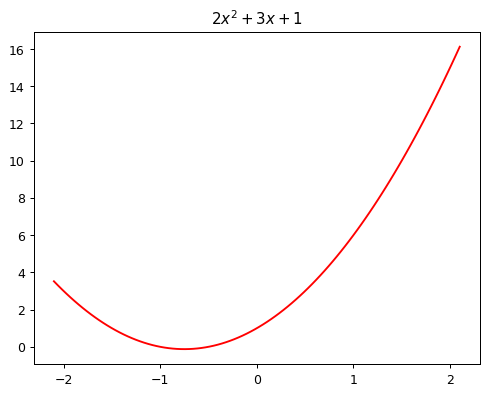

In [4]:
def quadratic(x):return 2*x**2 + 3*x + 1
plot_function(quadratic, "$2x^2 + 3x + 1$")

In [5]:
def quadratic_general(a, b, c, x): return a*x**2 + b*x + c
def mk_quadratic(a, b, c): return partial(quadratic_general, a, b, c)

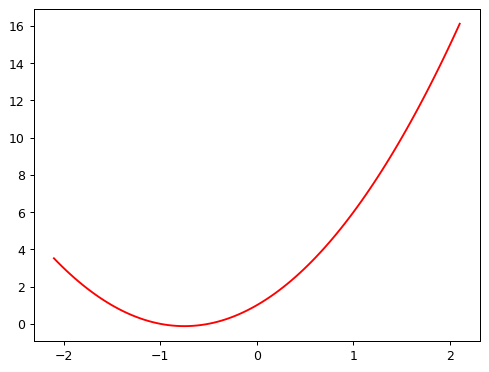

In [6]:
f = mk_quadratic(2, 3, 1)
plot_function(f)

## Generate random data and add noise

In [7]:
import numpy as np
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape) #scale-> std dev
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [8]:
import torch
np.random.seed(42)
x = torch.linspace(-5,5,steps=1000)[:None]
y = f(x)
y = add_noise(y, 0.5, 1)

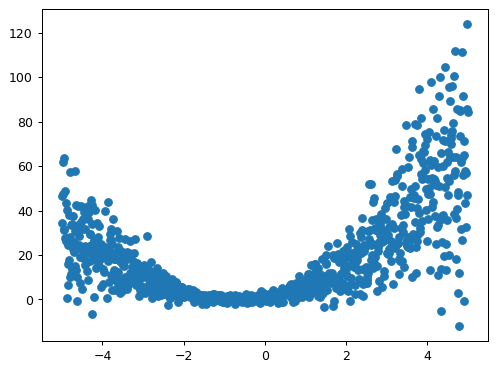

In [9]:
plt.scatter(x, y)

In [10]:
x.shape, y.shape

(torch.Size([1000]), torch.Size([1000]))

## Define ReLU function and loss function

In [11]:
def rectified_linear(m,b,x):
	y = m*x + b
	return torch.clip(y, 0.0)

def mse(act, pred): return ((act-pred)**2).mean()

## 1. Model the function using a single ReLU

Define the parameters for single ReLU

In [13]:
np.random.seed(42)
params1 = np.random.randn(2)
params1 = torch.tensor(params1)
params1.requires_grad_()

tensor([ 0.4967, -0.1383], dtype=torch.float64, requires_grad=True)

In [14]:
def mk_relu(m, b): return partial(rectified_linear, m, b)

In [15]:
def compute_mse(params):
    relu = mk_relu(*params)
    return mse(relu(x), y)

In [17]:
np.random.seed(42)
params1 = np.random.rand(2)
params1 = torch.tensor(params1)
params1.requires_grad_()

for i in range(20):
    loss = compute_mse(params1)
    loss.backward()
    with torch.no_grad(): 
        params1 -= (0.01*params1.grad)
        params1.grad.zero_()
    print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 1 Loss: 729.58
Epoch 2 Loss: 650.14
Epoch 3 Loss: 583.46
Epoch 4 Loss: 528.38
Epoch 5 Loss: 482.88
Epoch 6 Loss: 445.29
Epoch 7 Loss: 414.23
Epoch 8 Loss: 388.57
Epoch 9 Loss: 367.36
Epoch 10 Loss: 349.83
Epoch 11 Loss: 335.34
Epoch 12 Loss: 323.36
Epoch 13 Loss: 313.45
Epoch 14 Loss: 305.26
Epoch 15 Loss: 298.48
Epoch 16 Loss: 292.86
Epoch 17 Loss: 288.21
Epoch 18 Loss: 284.36
Epoch 19 Loss: 281.17
Epoch 20 Loss: 278.52


**Best Loss: 278.52**

In [18]:
params1

tensor([8.7314, 2.9535], dtype=torch.float64, requires_grad=True)

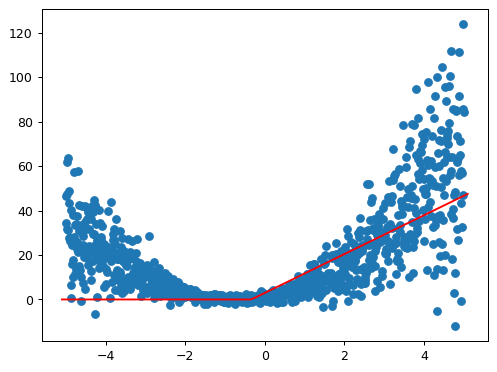

In [19]:
plt.scatter(x,y)
plot_function(mk_relu(*(params1.detach().numpy())), min=-5.1, max=5.1)

## 2. Model using double ReLU

This will be an unoptimized version first

In [20]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [21]:
def mk_double_relu(m1, b1, m2, b2): return partial(double_relu, m1, b1, m2, b2)

In [22]:
def compute_mse(params):
    double_relu = mk_double_relu(*params)
    return mse(double_relu(x), y)

In [23]:
np.random.seed(42)
params2 = np.random.rand(4)
params2 = torch.tensor(params2)
params2.requires_grad_()

for i in range(20):
    loss = compute_mse(params2)
    loss.backward()
    with torch.no_grad(): 
        params2 -= (0.01*params2.grad)
        params2.grad.zero_()
    print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 1 Loss: 653.71
Epoch 2 Loss: 526.75
Epoch 3 Loss: 440.98
Epoch 4 Loss: 383.61
Epoch 5 Loss: 345.20
Epoch 6 Loss: 319.48
Epoch 7 Loss: 302.23
Epoch 8 Loss: 290.65
Epoch 9 Loss: 282.86
Epoch 10 Loss: 277.59
Epoch 11 Loss: 274.02
Epoch 12 Loss: 271.58
Epoch 13 Loss: 269.90
Epoch 14 Loss: 268.73
Epoch 15 Loss: 267.89
Epoch 16 Loss: 267.29
Epoch 17 Loss: 266.83
Epoch 18 Loss: 266.48
Epoch 19 Loss: 266.19
Epoch 20 Loss: 265.96


**Best loss = 265.96**

In [24]:
params2

tensor([4.8446, 1.7464, 5.2161, 1.3879], dtype=torch.float64,
       requires_grad=True)

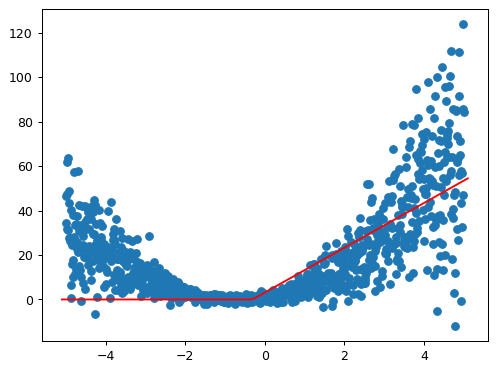

In [25]:
plt.scatter(x,y)
plot_function(mk_double_relu(*(params2.detach().numpy())), min=-5.1, max=5.1)

## Weighted ReLU combination

Now we will add ReLU with weights
(unoptimized code)

In [26]:
def double_relu_weighted(m1, b1, m2, b2, w1, w2, x):
    return w1 * rectified_linear(m1, b1, x) + w2 * rectified_linear(m2, b2, x)

In [27]:
def mk_double_relu_weighted(m1, b1, m2, b2, w1, w2): return partial(double_relu_weighted, m1, b1, m2,\
                                                                    b2, w1, w2)

In [28]:
np.random.seed(42)
params3 = np.random.randn(6)
params3

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696])

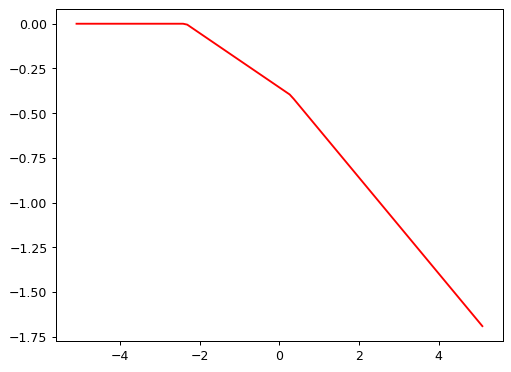

In [29]:
plot_function(mk_double_relu_weighted(*(params3)), min=-5.1, max=5.1)

In [30]:
def compute_mse(params):
    double_relu_weighted = mk_double_relu_weighted(*params)
    return mse(double_relu_weighted(x), y)

In [32]:
np.random.seed(42)
params3 = np.random.randn(6)
params3 = torch.tensor(params3)
params3.requires_grad_()

for i in range(50):
    loss = compute_mse(params3)
    loss.backward()
    with torch.no_grad(): 
        params3 -= (0.01*params3.grad)
        params3.grad.zero_()
    print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 1 Loss: 822.29
Epoch 2 Loss: 722.23
Epoch 3 Loss: 577.60
Epoch 4 Loss: 320.64
Epoch 5 Loss: 289.67
Epoch 6 Loss: 290.34
Epoch 7 Loss: 281.66
Epoch 8 Loss: 281.42
Epoch 9 Loss: 276.70
Epoch 10 Loss: 276.20
Epoch 11 Loss: 273.13
Epoch 12 Loss: 272.56
Epoch 13 Loss: 270.37
Epoch 14 Loss: 269.79
Epoch 15 Loss: 268.11
Epoch 16 Loss: 267.56
Epoch 17 Loss: 266.23
Epoch 18 Loss: 265.70
Epoch 19 Loss: 264.60
Epoch 20 Loss: 264.11
Epoch 21 Loss: 263.18
Epoch 22 Loss: 262.72
Epoch 23 Loss: 261.92
Epoch 24 Loss: 261.49
Epoch 25 Loss: 260.79
Epoch 26 Loss: 260.38
Epoch 27 Loss: 259.77
Epoch 28 Loss: 259.39
Epoch 29 Loss: 258.84
Epoch 30 Loss: 258.48
Epoch 31 Loss: 257.98
Epoch 32 Loss: 257.64
Epoch 33 Loss: 257.19
Epoch 34 Loss: 256.87
Epoch 35 Loss: 256.46
Epoch 36 Loss: 256.16
Epoch 37 Loss: 255.78
Epoch 38 Loss: 255.51
Epoch 39 Loss: 255.16
Epoch 40 Loss: 254.91
Epoch 41 Loss: 254.58
Epoch 42 Loss: 254.35
Epoch 43 Loss: 254.05
Epoch 44 Loss: 253.84
Epoch 45 Loss: 253.56
Epoch 46 Loss: 253.

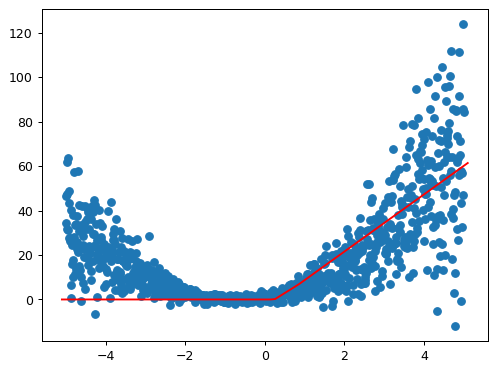

In [33]:
plt.scatter(x,y)
plot_function(mk_double_relu_weighted(*(params3.detach().numpy())), min=-5.1, max=5.1)

## Use basic torch nn

Trying to first doing this using standard torch nn models

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim


In [35]:
# Define the neural network model
class SimpleQuadraticNN(nn.Module):
    def __init__(self):
        super(SimpleQuadraticNN, self).__init__()
        # Define the hidden layer with 5 ReLU units
        self.hidden = nn.Linear(1, 5)  # 1 input feature, 5 hidden units
        self.relu = nn.ReLU()  # ReLU activation
        # Define the output layer with 1 unit
        self.output = nn.Linear(5, 1)  # 5 hidden units, 1 output

    def forward(self, x):
        # Forward pass through the hidden layer and ReLU activation
        x = self.hidden(x)
        x = self.relu(x)
        # Forward pass through the output layer
        x = self.output(x)
        return x


In [36]:
# Create an instance of the model
model = SimpleQuadraticNN()

In [37]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

In [38]:
def train(model, criterion, optimizer, x_train, y_train, epochs=1000):
    for epoch in range(epochs):
        model.train()
        
        # Convert data to tensors
        x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single feature
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single target
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_train_tensor)
        
        # Compute loss
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print loss every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [39]:
x.shape, y.shape

(torch.Size([1000]), torch.Size([1000]))

In [40]:
train(model, criterion, optimizer, x, y)

/tmp/ipykernel_33/235645135.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single feature
/tmp/ipykernel_33/235645135.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single target


Epoch [100/1000], Loss: 394.5826
Epoch [200/1000], Loss: 183.9216
Epoch [300/1000], Loss: 170.5625
Epoch [400/1000], Loss: 160.8855
Epoch [500/1000], Loss: 154.2833
Epoch [600/1000], Loss: 150.0141
Epoch [700/1000], Loss: 147.3179
Epoch [800/1000], Loss: 145.6054
Epoch [900/1000], Loss: 144.5400
Epoch [1000/1000], Loss: 143.8509


In [41]:
model

SimpleQuadraticNN(
  (hidden): Linear(in_features=1, out_features=5, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=5, out_features=1, bias=True)
)

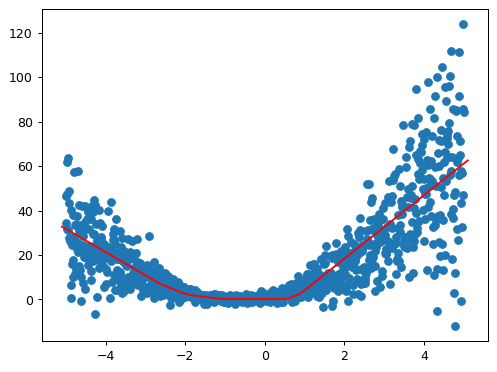

In [42]:
model.eval()  # Set model to evaluation mode
plt.scatter(x,y)

with torch.no_grad():
    plot_function(model, min=-5.1, max=5.1)

In [43]:
# Print the parameters of the model
def print_model_parameters(model):
    print("Model Parameters:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.data}")

# Example usage
print_model_parameters(model)

Model Parameters:
hidden.weight: tensor([[-1.5469],
        [ 2.7686],
        [-1.6842],
        [-1.6409],
        [ 3.0455]])
hidden.bias: tensor([-3.9990, -2.5009, -1.8678, -3.1659, -1.7219])
output.weight: tensor([[2.3622, 2.5090, 1.3483, 2.7352, 2.3990]])
output.bias: tensor([0.2575])


## Code this using only torch tensors

Now we create our own code to handle the weighted combinations of the ReLUs

In [44]:
def multi_relu(w1, w2, x):
    """
    MultiReLU is capable to handling weighted combination of any number of ReLU s possible.
    Parameters:
    - w1 : A matrix of size d * 2, where d is the size of the hidden layer (no of ReLUs we use)
           Every ReLU is a seperate row with the m and b part of its column
    - w2 : These are individual weights to combine the ReLUs plus the bias term
    - x : input variable of size N where N are the no of data points
    """
    
    # Step 1: Add the bias feature in a separate row to make x of size N * 2
    x = x.reshape((len(x), 1))
    ones = torch.ones(x.shape)
    x_bias = torch.cat((x, ones), dim=1)
    
    # Step 2: Matrix multiply x_bias with w1. Apply ReLU
    hidden = x_bias @ w1.T
    hidden_relu = torch.clip(hidden, 0.0)
    
    # Step 3: Add the bias parameter to the hidden
    ones2 = torch.ones((hidden_relu.shape[0], 1))
    hidden_relu_bias = torch.cat((hidden_relu, ones2), dim=1)
    
    # Step 4: Multiply with w2 to combine ReLU s
    y_pred = hidden_relu_bias @ w2
    
    return y_pred.flatten()

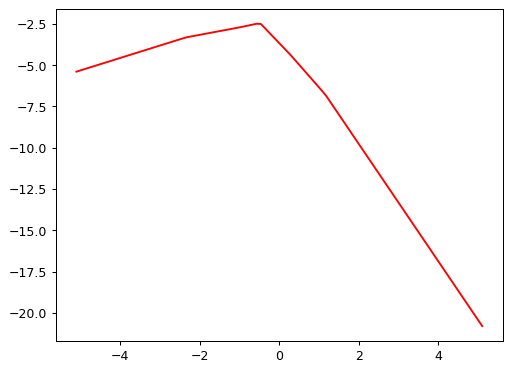

In [45]:
np.random.seed(42)
w1 = np.random.randn(5,2)
w2 = np.random.randn(6,1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

plot_function(partial(multi_relu, w1, w2), min=-5.1, max=5.1)

Now train the network.

In [47]:
def compute_mse(w1, w2):
    multi_relu_fixed = partial(multi_relu, w1, w2)
    return mse(multi_relu_fixed(x), y)

### Fixed lr

In [48]:
# np.random.seed(42)
w1 = np.random.randn(5,2)
w2 = np.random.randn(6,1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

for i in range(1000):
    loss = compute_mse(w1, w2)
    loss.backward()
    
    with torch.no_grad(): 
        w1 -= (lr*w1.grad)
        w2 -= (lr*w2.grad)
        
        w1.grad.zero_()
        w2.grad.zero_()
        
    if (i+1) % 100 == 0:
#         print(lr)
        print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 100 Loss: 155.65
Epoch 200 Loss: 150.40
Epoch 300 Loss: 148.57
Epoch 400 Loss: 147.42
Epoch 500 Loss: 145.98
Epoch 600 Loss: 145.66
Epoch 700 Loss: 144.84
Epoch 800 Loss: 144.39
Epoch 900 Loss: 143.83
Epoch 1000 Loss: 143.58


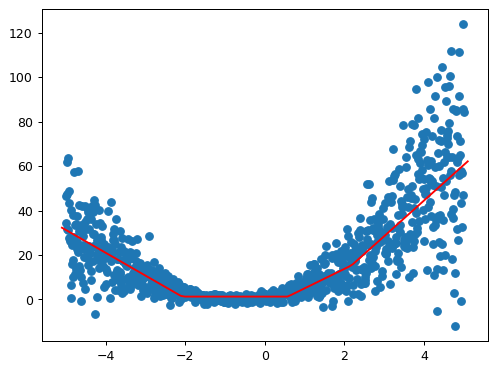

In [49]:
plt.scatter(x,y)
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-5.1, max=5.1)

Larger models

In [56]:
# np.random.seed(42)
w1 = np.random.randn(10,2)
w2 = np.random.randn(11,1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

for i in range(1000):
    loss = compute_mse(w1, w2)
    loss.backward()
    
    with torch.no_grad(): 
        w1 -= (lr*w1.grad)
        w2 -= (lr*w2.grad)
        
        w1.grad.zero_()
        w2.grad.zero_()
        
    if (i+1) % 100 == 0:
#         print(lr)
        print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 100 Loss: 170.14
Epoch 200 Loss: 159.22
Epoch 300 Loss: 156.09
Epoch 400 Loss: 153.82
Epoch 500 Loss: 151.73
Epoch 600 Loss: 149.69
Epoch 700 Loss: 148.13
Epoch 800 Loss: 146.28
Epoch 900 Loss: 145.75
Epoch 1000 Loss: 145.32


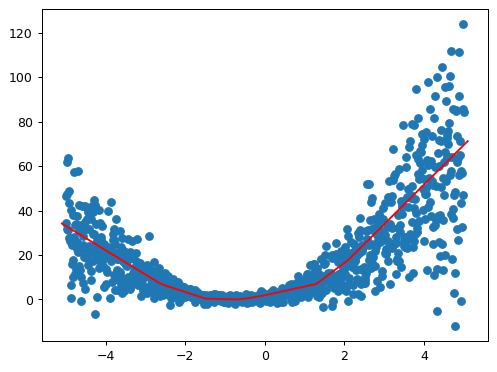

In [57]:
plt.scatter(x,y)
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-5.1, max=5.1)

### lr scheduler

In [53]:
# np.random.seed(42)
w1 = np.random.randn(5,2)
w2 = np.random.randn(6,1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

for i in range(1000):
    loss = compute_mse(w1, w2)
    loss.backward()
    
    with torch.no_grad(): 
        w1 -= (lr*w1.grad)
        w2 -= (lr*w2.grad)
        
        w1.grad.zero_()
        w2.grad.zero_()
        
    if (i+1) % 10 == 0:
        lr *= 0.99
        
    if (i+1) % 100 == 0:
#         print(lr)
        print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 100 Loss: 150.85
Epoch 200 Loss: 145.39
Epoch 300 Loss: 142.99
Epoch 400 Loss: 141.96
Epoch 500 Loss: 141.53
Epoch 600 Loss: 141.32
Epoch 700 Loss: 141.21
Epoch 800 Loss: 141.14
Epoch 900 Loss: 141.10
Epoch 1000 Loss: 141.06


Slightly better loss

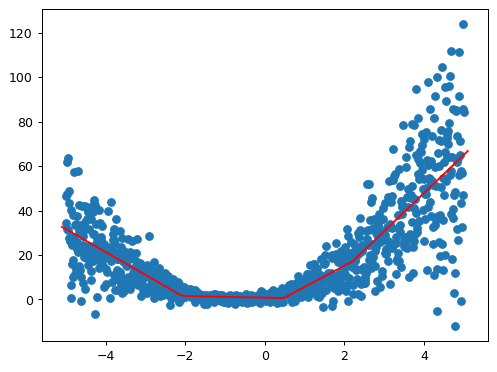

In [54]:
plt.scatter(x,y)
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-5.1, max=5.1)

In [58]:
# np.random.seed(42)
w1 = np.random.randn(10,2)
w2 = np.random.randn(11,1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

for i in range(1000):
    loss = compute_mse(w1, w2)
    loss.backward()
    
    with torch.no_grad(): 
        w1 -= (lr*w1.grad)
        w2 -= (lr*w2.grad)
        
        w1.grad.zero_()
        w2.grad.zero_()
        
    if (i+1) % 10 == 0:
        lr *= 0.99
        
    if (i+1) % 100 == 0:
#         print(lr)
        print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 100 Loss: 145.45
Epoch 200 Loss: 142.71
Epoch 300 Loss: 141.81
Epoch 400 Loss: 141.37
Epoch 500 Loss: 141.13
Epoch 600 Loss: 140.97
Epoch 700 Loss: 140.85
Epoch 800 Loss: 140.76
Epoch 900 Loss: 140.70
Epoch 1000 Loss: 140.68


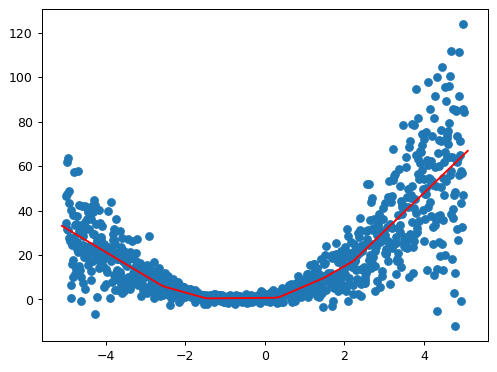

In [59]:
plt.scatter(x,y)
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-5.1, max=5.1)